In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

import sys
import os
# 使用当前工作目录
project_root = os.path.dirname(os.getcwd())  # 获取当前目录的父目录
sys.path.insert(0, project_root)
from util.methods import assign_variances

seed = 15
# 定义核函数
kernel = ConstantKernel(25.0) * RBF(length_scale=4.0) + WhiteKernel(1e-3)
gp = GaussianProcessRegressor(kernel=kernel)

x_dense = np.linspace(1, 200, 2000).reshape(-1, 1)

y_dense = gp.sample_y(x_dense, n_samples=1, random_state=seed).flatten() + 70

# 提取整数点对应的y值
integer_points = np.arange(1, 201)
y_integers = y_dense[np.linspace(0, 1999, 200, dtype=int)]

# 计算整数点的协方差矩阵
cov_matrix = kernel(integer_points.reshape(-1,1))

# 计算相关性矩阵
std_dev = np.sqrt(np.diag(cov_matrix))  
corr_matrix = cov_matrix / np.outer(std_dev, std_dev)  

np.savetxt('Sigma1.txt', cov_matrix, 
           fmt='%.6f',
           header=f'高斯过程协方差矩阵\n核函数: {kernel}')

np.savetxt('correlation_matrix.txt', corr_matrix,
           fmt='%.6f',
           header=f'高斯过程相关性矩阵\n核函数: {kernel}')

np.savetxt('mu.txt', 
           y_integers,
           fmt='%.6f',
           header='真实均值')

# 创建分组标签 (5组，每组10个点)
group_labels = np.floor(np.argsort(np.argsort(y_integers))/25).astype(int)
group_names = [f"第{i+1}组" for i in range(8)]  # 组别名称

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_dense.flatten(), 
    y=y_dense,
    mode='lines',
    name='GP曲线',
    line=dict(color='royalblue', width=2)
))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#f5fa07', '#07faec', '#f808b9']  # 8种不同颜色
for group in range(8):
    mask = (group_labels == group)
    fig.add_trace(go.Scatter(
        x=integer_points[mask],
        y=y_integers[mask],
        mode='markers',
        name=group_names[group],
        marker=dict(
            color=colors[group],
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
    )))

fig.update_layout(
    title='高斯过程曲线与分组结果',
    xaxis_title='x',
    yaxis_title='f(x)',
    template='plotly_white',
    height=1080,
    width=1920,
    legend=dict(
        title='组别',
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.8)'
    ),
    margin=dict(r=150) 
)

fig.show()

In [2]:
eigvals = np.linalg.eigvals(cov_matrix)
print("最小特征值:", np.min(eigvals))
print("负特征值数量:", np.sum(eigvals < 0))

最小特征值: (0.0009999999999902897+0j)
负特征值数量: 0


验证结果:
对角线均值: 1.000000 (目标: 1.0)
最小特征值: 0.000000+0.000000j (应>0)


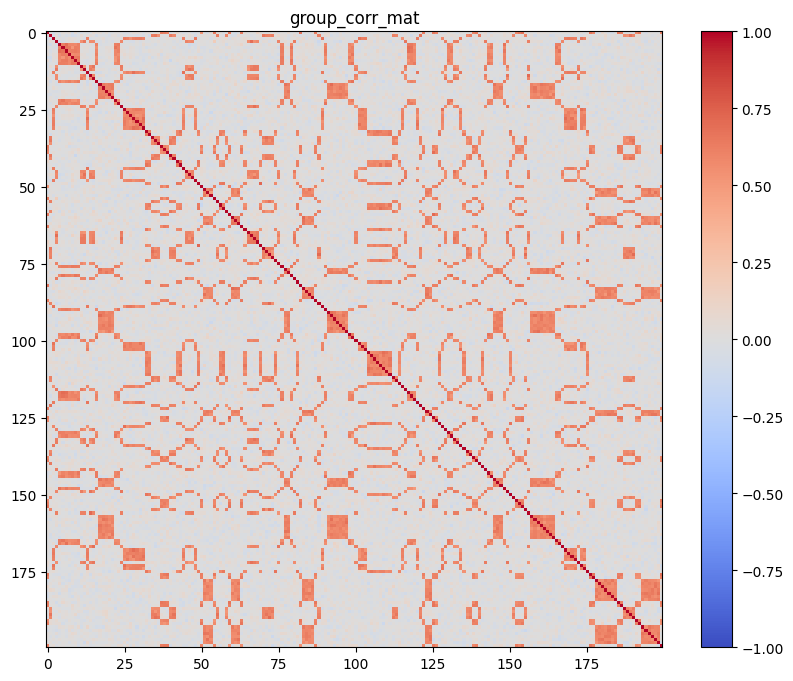

In [3]:
import numpy as np
from scipy.linalg import cholesky
import matplotlib.pyplot as plt

# 初始化参数
n_points = 200
within_group_mean = 0.8
between_group_mean = 0.0
noise_std = 0.1 

def build_correlation_matrix(group_labels):
    groups = np.unique(group_labels)
    n_groups = len(groups)
    group_mask = group_labels[:, None] == group_labels  
    
    base_matrix = np.where(group_mask, 
                          within_group_mean, 
                          between_group_mean)
    np.fill_diagonal(base_matrix, 1.0)
    
    random_matrix = np.random.normal(0, noise_std, (n_points, n_points))
    random_matrix = (random_matrix + random_matrix.T) / 2  
    np.fill_diagonal(random_matrix, 0) 
    
    corr_matrix = base_matrix + random_matrix
    

    def project_to_pd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals = np.maximum(eigvals, 1e-8)  
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    

    for _ in range(10):
        corr_matrix = project_to_pd(corr_matrix)
        # 重新标准化对角线
        diag_scaling = np.diag(1/np.sqrt(np.diag(corr_matrix)))
        corr_matrix = diag_scaling @ corr_matrix @ diag_scaling
    
    return corr_matrix

corr_matrix = build_correlation_matrix(group_labels)

# 验证矩阵性质
print("验证结果:")
print(f"对角线均值: {np.mean(np.diag(corr_matrix)):.6f} (目标: 1.0)")
print(f"最小特征值: {np.min(np.linalg.eigvals(corr_matrix)):.6f} (应>0)")

# 可视化矩阵
plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("group_corr_mat")
plt.show()

In [4]:
group_labels+1

array([7, 6, 4, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 3, 3, 2, 1, 1, 1, 1, 1,
       2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7, 7, 6, 6, 5, 5,
       4, 3, 3, 3, 4, 5, 7, 8, 8, 8, 7, 6, 5, 5, 6, 7, 8, 8, 8, 7, 5, 3,
       3, 3, 3, 5, 6, 6, 6, 6, 5, 3, 2, 1, 1, 2, 3, 5, 7, 8, 8, 8, 8, 7,
       6, 4, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 6, 6, 5, 4, 3, 2, 2, 2, 4, 6, 7, 8, 8, 7, 7, 5, 4, 3, 2, 2,
       3, 3, 4, 5, 6, 6, 7, 7, 6, 5, 3, 2, 2, 1, 1, 1, 2, 3, 5, 6, 7, 7,
       7, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 4, 4, 3, 4, 4, 5,
       7, 7, 8, 8, 8, 8, 8, 8, 8, 7, 7, 6, 6, 6, 6, 7, 7, 8, 8, 8, 8, 8,
       8, 7])

验证结果:
方差范围: 29.58-132.86 (目标: 25-144)
最小特征值: 0.000000 (应>0)


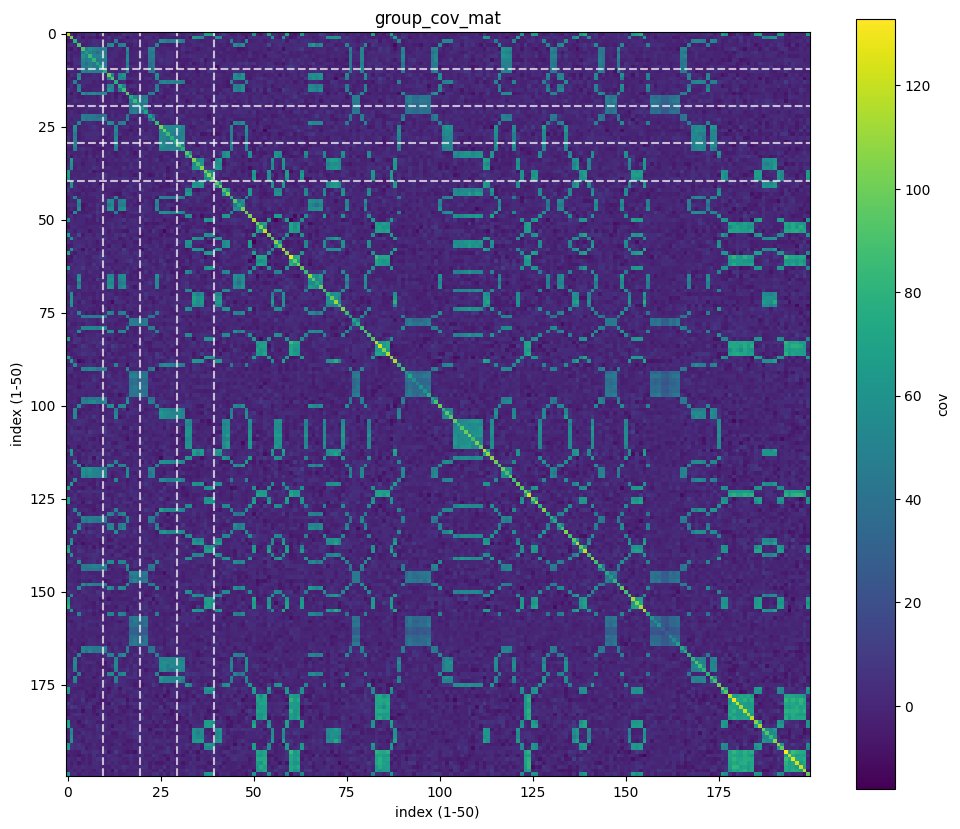

In [5]:
# 随机分配噪声
np.random.seed(seed)  
variances = assign_variances(y_integers, min_var=25, max_var=144, correlation_strength=0.7)
#variances = variances*4
std_devs = np.sqrt(variances)  

D = np.diag(std_devs)

cov_matrix = D @ corr_matrix @ D

print("验证结果:")
print(f"方差范围: {np.min(np.diag(cov_matrix)):.2f}-{np.max(np.diag(cov_matrix)):.2f} (目标: 25-144)")
print(f"最小特征值: {np.min(np.linalg.eigvals(cov_matrix)):.6f} (应>0)")

np.savetxt('group_cov.txt', 
           cov_matrix,
           fmt='%.6f',
           header='协方差矩阵（对角线方差=25-144）\n基于分组相关性矩阵生成')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.imshow(cov_matrix, cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('cov')

for g in range(1,5):
    plt.axhline(y=g*10-0.5, color='white', linestyle='--', alpha=0.7)
    plt.axvline(x=g*10-0.5, color='white', linestyle='--', alpha=0.7)

plt.title('group_cov_mat')
plt.xlabel('index (1-50)')
plt.ylabel('index (1-50)')
plt.show()


In [6]:
y_integers

array([73.64811379, 72.27836357, 70.50216565, 68.82880856, 67.41761976,
       66.54416482, 66.20681742, 66.21641052, 66.57156156, 67.1887892 ,
       67.93481011, 68.85282816, 69.64858797, 70.04598043, 69.72620669,
       68.71667283, 67.13625888, 65.46026734, 64.15392099, 63.61587297,
       64.03586401, 65.31535784, 66.8750639 , 68.55106219, 69.70669808,
       70.39796497, 70.71437804, 70.61961236, 70.3280096 , 69.9893301 ,
       70.03226309, 70.4095258 , 71.0155659 , 71.78228166, 72.50465426,
       72.84162615, 73.05346978, 73.20038207, 73.20610025, 73.25909981,
       73.06704671, 72.50422711, 71.77255033, 70.91407026, 69.9416297 ,
       69.14676946, 68.85559271, 69.13601979, 70.09843799, 71.7846929 ,
       73.577074  , 75.08861389, 75.6785477 , 75.26477007, 73.97352368,
       72.56053887, 71.75016051, 71.78314743, 72.88564596, 74.47553881,
       75.75354231, 76.12952035, 75.48626523, 73.75668677, 71.65051717,
       69.74202074, 68.67481697, 68.73183296, 69.68618003, 71.05

In [7]:
variances

array([120.42779736,  99.41296541,  79.18586725,  90.79356309,
        90.8216746 ,  63.70905029,  84.52937503,  80.67930832,
        72.18640883,  73.58124423,  75.99560978,  97.87485232,
        91.37109009,  77.61590118,  76.79078961,  87.01833984,
        96.7141353 ,  72.77850643,  86.15502074,  64.7807806 ,
        62.45838738,  70.67247152,  65.61605329,  69.48994347,
        83.70041661, 102.40595106,  99.7362623 ,  84.34843307,
        77.03943497,  76.87041664,  93.00094484,  76.6350146 ,
        94.27938972,  94.89098199, 104.10142054,  88.83427313,
       106.23562863, 100.84882548, 107.17580357,  93.4490814 ,
        94.72247677,  99.47113518,  90.01104671, 101.00050079,
        76.75747877,  94.71911427,  71.31069919, 103.67579558,
        97.48113401, 103.13615791, 112.87094547, 102.40847958,
       103.7183267 , 119.37209831, 101.2103352 ,  93.12430986,
       103.9055261 ,  95.91022542, 113.70275894, 103.32173844,
       129.31030019,  97.5418403 , 101.49013479,  95.11